In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import category_encoders as ce

In [2]:
df_input = pd.read_csv('./data/train.csv')
df_input.pop('Id')

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: Id, Length: 1000, dtype: int64

In [3]:
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(df_input)
df_encoded.tail()

,BldgType_1Fam,BldgType_2FmCon,BldgType_Duplx,BldgType_TwnhsE,BldgType_TwnhsI,OverallQual,GrLivArea,GarageArea,SalePrice
995,1,0,0,0,0,4,1230,305,121600
996,1,0,0,0,0,5,1050,368,136500
997,1,0,0,0,0,6,1442,615,185000
998,1,0,0,0,0,3,1077,210,91000
999,1,0,0,0,0,7,1208,632,206000


In [4]:
x_train = df_encoded.sample(frac=0.8,random_state=0)
x_test = df_encoded.drop(x_train.index)

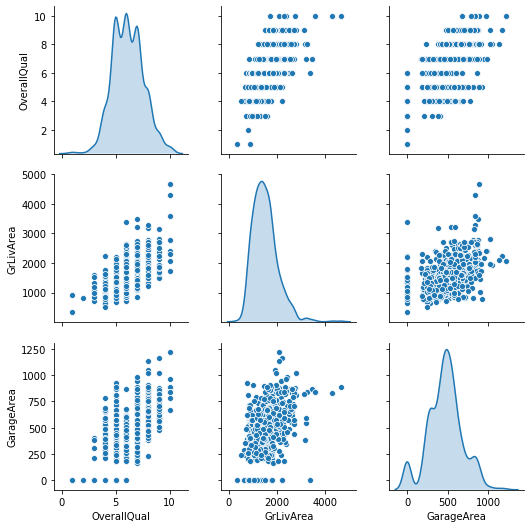

In [5]:
sns.pairplot(x_train[["OverallQual", "GrLivArea", "GarageArea"]], diag_kind="kde")

In [6]:
y_train = x_train.pop('SalePrice')
y_test = x_test.pop('SalePrice')

In [7]:
train_stats = x_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
BldgType_1Fam,800.0,0.83875,0.367991,0.0,1.00,1.0,1.00,1.0
BldgType_2FmCon,800.0,0.01875,0.135726,0.0,0.00,0.0,0.00,1.0
BldgType_Duplx,800.0,0.03875,0.193119,0.0,0.00,0.0,0.00,1.0
BldgType_TwnhsE,800.0,0.07375,0.261527,0.0,0.00,0.0,0.00,1.0
BldgType_TwnhsI,800.0,0.03000,0.170694,0.0,0.00,0.0,0.00,1.0
OverallQual,800.0,6.15625,1.404208,1.0,5.00,6.0,7.00,10.0
GrLivArea,800.0,1519.81250,514.256850,334.0,1144.75,1456.0,1776.75,4676.0
GarageArea,800.0,472.35375,210.261512,0.0,336.00,480.0,576.00,1220.0


In [8]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_x_train = norm(x_train)
normed_x_test = norm(x_test)

In [9]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [10]:
model = build_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


In [12]:
# example_batch = normed_train_data[:10]
# example_result = model.predict(example_batch)
# example_result

In [13]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



history = model.fit(
  normed_x_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


.............................................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
72,1.523629e+09,24898.521484,1.523629e+09,972822412.8,23667.857422,972822400.0,72
73,1.536687e+09,24967.402344,1.536687e+09,956519590.4,23683.488281,956519616.0,73
74,1.509883e+09,25026.023438,1.509883e+09,985929484.8,23792.080078,985929536.0,74
75,1.512449e+09,24928.753906,1.512449e+09,996693145.6,23882.136719,996693184.0,75
76,1.514813e+09,25181.074219,1.514813e+09,951962918.4,23806.074219,951962944.0,76


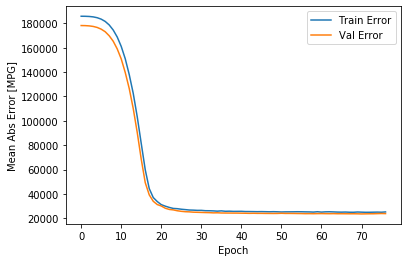

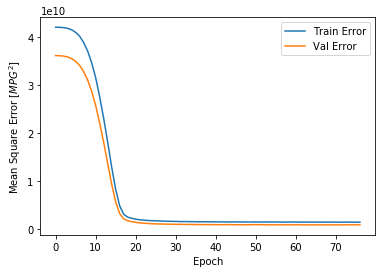

In [15]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  # plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

In [16]:
newdata = df_encoded
new_label = newdata.pop('SalePrice')
normed_train = norm(newdata)

In [17]:
new_predict = model.predict(normed_train)
new_predict = new_predict.astype(int)

In [18]:
df = pd.DataFrame({'Actual': new_label, 'Predicted': new_predict.flatten()})
df

,Actual,Predicted
0,208500,213879
1,181500,148942
2,223500,224087
3,140000,223576
4,250000,317900
...,...,...
995,121600,107059
996,136500,117183
997,185000,171973
998,91000,95982


In [24]:
((df.Actual - df.Predicted) ** 2).mean()

1289852716.129

In [25]:
(((df.Actual - df.Predicted) ** 2) / (df.Actual ** 2)).mean()

0.05537611932809523

In [20]:

# for index, row in df.iterrows():
#     print(row['Actual'], row['Predicted'])

In [21]:
test_input = pd.read_csv('./data/test.csv')
id_col = test_input.pop('Id')

In [22]:
encode_input = encoder.fit_transform(test_input)
normed_test_input = norm(encode_input)
test_predict = model.predict(normed_test_input)
test_predict = test_predict.astype(int)
df_test_result = pd.DataFrame({'Id': id_col, 'SalePrice': test_predict.flatten()})
df_test_result

,Id,SalePrice
0,1202,210992
1,1203,113859
2,1204,181377
3,1205,139115
4,1206,273762
...,...,...
254,1456,169321
255,1457,202392
256,1458,182687
257,1459,110441


In [23]:
df_test_result.to_csv(r'./data/submission.csv', index=None)